[View in Colaboratory](https://colab.research.google.com/github/Abey12525/PYTHON_GEN/blob/master/Kmnist.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#loading data 
data = tf.keras.datasets.mnist
(train_x, train_y),(test_x,test_y) = data.load_data()
enc = OneHotEncoder()
#data before conversion
print("test : {}".format(test_y[0]))
print("train : {}".format(train_y[0]))
test_y = test_y.reshape(-1,1)
train_y = train_y.reshape(-1,1)
#converting scalar value to one-hot encoding
enc.fit(train_y)
train_y = enc.transform(train_y).toarray()
enc.fit(test_y)
test_y = enc.transform(test_y).toarray()
#after conversion
print("test : {}".format(test_y[0]))
print("train : {}".format(train_y[0]))
print("shape = {}".format(train_y.shape))


test : 7
train : 5
test : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
train : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
shape = (60000, 10)


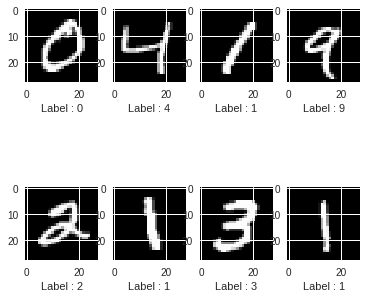

In [13]:
def figsub(imgarr,labarr):
  fig = plt.figure(figsize=(6,6))
  columns = 4
  rows = 2
  for i in range(1,columns*rows+1):
    img = imgarr[i]
    img = np.array(img)
    img = img.reshape((28,28))
    fig.add_subplot(rows,columns,i)
    plt.imshow(img,cmap='gray')
    plt.xlabel("Label : {}".format(np.argmax(labarr[i],axis=0)))

    
def figsubpre(imgarr,labarr,pre):
  fig = plt.figure(figsize=(8,8))
  columns = 4
  rows = 2
  for i in range(1,columns*rows+1):
    img = imgarr[i]
    img = np.array(img)
    img = img.reshape((28,28))
    fig.add_subplot(rows,columns,i)
    plt.imshow(img,cmap='gray')
    plt.xlabel("Label : {} Prediction : {}".format(np.argmax(labarr[i],axis=0),pre[i]))
    
figsub(train_x,train_y)

In [4]:
#reshaping data to use in convolution
train_x = train_x.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)
print(train_x.shape)
print(test_x.shape)
x = tf.placeholder("float",[None,28,28,1])
y = tf.placeholder("float",[None,10])


(60000, 28, 28, 1)
(10000, 28, 28, 1)


#  Define the model

In [0]:
def conv2d(x,w,b,strides = 1):
    x = tf.nn.conv2d(x,w,strides=[1,strides,strides,1],padding = 'SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.softmax(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding = 'SAME')
    

In [0]:
n_classes = 10
n_input = 28
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W4', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}

bias = {
    'bc0':tf.get_variable('B0', shape=(32),initializer = tf.contrib.layers.xavier_initializer()),
    'bc2':tf.get_variable('B1', shape=(64),initializer = tf.contrib.layers.xavier_initializer()),
    'bc3':tf.get_variable('B2', shape=(128),initializer = tf.contrib.layers.xavier_initializer()),
    'bd1':tf.get_variable('B3', shape=(128),initializer = tf.contrib.layers.xavier_initializer()),
     'out':tf.get_variable('B4', shape=(10),initializer = tf.contrib.layers.xavier_initializer())
}

    


In [0]:
def mn_conv(x,weights,bias):
    #first layer of convolution 
    conv1 = conv2d(x,weights['wc1'],bias['bc0'])
    #pooling layer 
    pool1 = maxpool2d(conv1)
    #second layer of convolution 
    conv2 = conv2d(pool1,weights['wc2'],bias['bc2'])
    #pooling layer 
    pool2 = maxpool2d(conv2)
    #third layer of conolution 
    conv3 = conv2d(pool2, weights['wc3'],bias['bc3'])
    #pooling layer 
    pool3 = maxpool2d(conv3)
    #flatining the output for dense layer input 
    den_inp = tf.reshape(pool3,[-1,weights['wd1'].get_shape().as_list()[0]])
    #the y = wx + b output 
    y = tf.add(tf.matmul(den_inp,weights['wd1']),bias['bd1'])
    #ReLU layer 
    rel = tf.nn.relu(y)
    #output , class prediction , second dense layer 
    den_2_inp = tf.add(tf.matmul(y,weights['out']),bias['out'])
    #return den_2_inp as output
    print("smaple {}".format(x))
    return den_2_inp
    


# Define Loss function & Optimizer

In [8]:
training_iters = 30
Lr_rate = 0.002
batch_size = 120

initilize = mn_conv(x,weights,bias)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = initilize,labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate = Lr_rate).minimize(cost)

smaple Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Optimize and Evaluate the Model

In [0]:
correct_prediction = tf.equal(tf.argmax(initilize,1),tf.argmax(y,1))
tt = tf.argmax(initilize,1)
accuracy = tf.reduce_mean(tf.cast(correct_prediction , tf.float32))

Training.....
Iter 0, Loss= 2.312573, Training Accuracy= 0.10000
Iter 1, Loss= 0.037416, Training Accuracy= 0.98333
Iter 2, Loss= 0.041301, Training Accuracy= 0.99167
Iter 3, Loss= 0.034545, Training Accuracy= 0.99167
Iter 4, Loss= 0.024625, Training Accuracy= 0.98333
Iter 5, Loss= 0.011166, Training Accuracy= 1.00000
Iter 6, Loss= 0.005662, Training Accuracy= 1.00000
Iter 7, Loss= 0.002644, Training Accuracy= 1.00000
Iter 8, Loss= 0.032904, Training Accuracy= 0.99167
Iter 9, Loss= 0.002189, Training Accuracy= 1.00000
Iter 10, Loss= 0.000148, Training Accuracy= 1.00000
Iter 11, Loss= 0.000125, Training Accuracy= 1.00000
Iter 12, Loss= 0.005741, Training Accuracy= 1.00000
Iter 13, Loss= 0.001804, Training Accuracy= 1.00000
Iter 14, Loss= 0.000365, Training Accuracy= 1.00000
Iter 15, Loss= 0.000147, Training Accuracy= 1.00000
Iter 16, Loss= 0.000145, Training Accuracy= 1.00000
Iter 17, Loss= 0.001209, Training Accuracy= 1.00000
Iter 18, Loss= 0.001360, Training Accuracy= 1.00000
Iter 19,

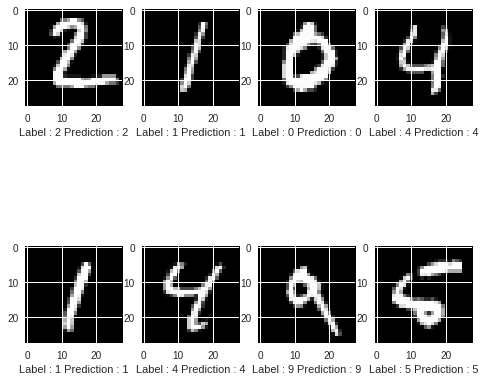

In [10]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()
#init_op = tf.initialize_all_variables()
bt_size = len(train_x)//batch_size
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    print("Training.....")
    for i in range(training_iters):
        for batch in range(bt_size):
            batch_x = train_x[batch*batch_size:min((batch+1)*batch_size,len(train_x))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]
            opt = sess.run(optimizer, feed_dict = {x:batch_x, y:batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict = {x:batch_x, y:batch_y})
            if(batch%500==0):
                print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                        "{:.5f}".format(acc))
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)
    print("Training Complete")
    #testing with test_data
    op_test = sess.run(tt,feed_dict={x: test_x,y : test_y})
    figsubpre(test_x,test_y,op_test)
    test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_x,y : test_y}) 
    
    summary_writer.close()

In [11]:
print(test_acc)

0.9885
